# What is the Unscented Transform?

## Ryan Dwyer 2016.09.16

# Outline

- Unscented transform
- Unscented Kalman filter

# Detailed outline

- Unscented transform
    - Non-linear transformations
    - Canonical example is Cartesian to polar coordinates
    - How do you transform error bars?
    - Standard way is to linearize (this is also the rule used in standard error propogation limits)
    - Show how this fails causes problems in non-linear applications, especially when the error bars get large!
    - Linearization would say no information here, which can cause problems.
    - Systems can become very brittle in the presense of large errors, since the errors are always propogated linearly.
    - Idea: take well-chosen points, put them through the full non-linear transformation, and then make a much better approximation!
    - Show linearized error, show unscented transform error.
- Unscented Kalman filter

## Example
- Determine error in $x$ from error in $A$, $\phi$.
  $$x = A \cos \phi$$
- Normal method: *Linearize!*
  $$\begin{align}
  \bar{x} + \delta x&  = (\bar{A} + \delta A) \cos (\bar{\phi} + \delta \phi) \\
  \bar{x}& = \bar{A} \cos \bar{\phi} \\
  \sigma_x^2& = \sigma_A^2 \cos^2 \bar{\phi} + \sigma_\phi^2 (\bar{A} \sin \bar{\phi})^2 
  \end{align}$$

In [39]:
%matplotlib inline
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import h5py
import ipywidgets as ipy
import uncertainties
from uncertainties import umath, ufloat
from matplotlib.patches import Ellipse
from matplotlib import colors

In [40]:
def svdsqrtm(x, eps=1e-13):
    """Return the matrix square root of x calculating using the svd.
    
    Set singular values < eps to 0.
    This prevents numerical errors from making sqrtm(x) complex
    (small eigenvalues of x accidently negative)."""
    u, s, v = linalg.svd(x)
    s_pos = np.zeros_like(s)
    for i in xrange(s.size):
        if s[i] > eps:
            s_pos[i] = s[i]

    return np.dot(u, np.dot(np.diag(np.sqrt(s_pos)), v.T))

In [41]:
def unscented(x, P):
    """For a vector x of length N with covariance matrix P,
    form 2N sigma points used for taking the unscented transform."""
    N = x.size
    Psqrt = svdsqrtm(N * P)
    x_sigma = np.zeros((N, 2*N))
    for i in xrange(N):
        x_sigma[:, i] = x + Psqrt[:, i]

    for i in xrange(N, 2*N):
        x_sigma[:, i] = x - Psqrt[:, i-N]

    return x_sigma

def unscented_mu_cov(x_sigma):
    N, N2 = x_sigma.shape
    x_mu = np.mean(x_sigma, axis=1)
    diff = x_sigma - x_mu.reshape((-1, 1))
    x_cov = np.dot(diff, diff.T) / N2
    return x_mu, x_cov

In [42]:
phis = np.linspace(0, 2*np.pi, 101)

uA = ufloat(1, 0.1)

def magphase(A, phi):
    return A * np.sin(phi)

def fill_donut(ax, radii, n=100, **kwargs):
    """Fill a donut between minimum radii and maximum radii.
    
    See http://stackoverflow.com/q/22789356"""
    phis = np.linspace(0, 2*np.pi, n)
    xs = np.outer(radii, np.cos(phis))
    ys = np.outer(radii, np.sin(phis))
    
    # in order to have a closed area, the circles
    # should be traversed in opposite directions
    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]
    
    return ax.fill(np.ravel(xs), np.ravel(ys), **kwargs)

def cov_ellipse(mu, cov, **kwargs):
    cov_vals, cov_vecs = linalg.eig(cov)
    
    return Ellipse(mu, 2*cov_vals[0].real**0.5, 2*cov_vals[1].real**0.5,
                      -np.arctan2(cov_vecs[0, 1], cov_vecs[0, 0])*180/np.pi,
                      **kwargs)


def magtime_phi_linear(mu_phi, sigma_A, sigma_phi):
    mu_x = magphase(1.0, mu_phi)
    cov = np.diag([sigma_A**2, sigma_phi**2])
    phi_x = phis[:51]
    fig, ax = plt.subplots(figsize=(8,8))
    axis_color='0.5'

    # Add axes
    ax.axhline(color=axis_color)
    ax.axvline(color=axis_color)
    
    # Mean circle (mu_A = 1)
    ax.plot(np.cos(phis), np.sin(phis))
    fill_donut(ax, [1-sigma_A, 1+sigma_A], edgecolor='none', alpha=0.1)
    
    
    ax.plot([0, np.cos(mu_phi)], [0, np.sin(mu_phi)], 'g')
    phi_plot = np.linspace(mu_phi+sigma_phi, mu_phi-sigma_phi, 9)
    ax.fill(np.r_[0, np.cos(phi_plot)], np.r_[0, np.sin(phi_plot)], 'g', alpha=0.1)
    ax.plot(np.cos(mu_phi), np.sin(mu_phi), 'ko', markeredgecolor='none')
    
    # Propogate error
    uA = ufloat(1.0, sigma_A)
    u_phi = ufloat(mu_phi, sigma_phi)
    ux = umath.cos(u_phi) * uA
    uy = umath.sin(u_phi) * uA
    ucov = np.array(uncertainties.covariance_matrix([ux, uy]))
    # Determine ellipse major and minor axes
    cov_vals, cov_vecs = linalg.eig(ucov)
    
    ellipse = Ellipse((ux.n, uy.n), 2*cov_vals[0].real**0.5, 2*cov_vals[1].real**0.5,
                      -np.arctan2(cov_vecs[0, 1], cov_vecs[0, 0])*180/np.pi,
                      color='c', alpha=0.5)
    ax.add_artist(ellipse)
    
    ax.set_xlim(-0.5, 1.25)
    ax.set_ylim(-0.5, 1.25)


def magtime_phi_exact(mu_phi, sigma_A, sigma_phi, xlim, ylim):
    mu_x = magphase(1.0, mu_phi)
    cov = np.diag([sigma_A**2, sigma_phi**2])
    phi_x = phis[:51]
    fig, ax = plt.subplots(figsize=(8,8))
    axis_color='0.5'
    
    # Add exact propogation of samples
    pts = 500
    A_pts = np.random.randn(pts)*sigma_A + 1
    phi_pts = np.random.randn(pts)*sigma_phi + mu_phi
    x_pts = A_pts * np.cos(phi_pts)
    y_pts = A_pts * np.sin(phi_pts)
    mu_xy = np.array([x_pts.mean(), y_pts.mean()])
    vec = np.c_[x_pts - x_pts.mean(), y_pts - y_pts.mean()]
    cov_pts = np.dot(vec.T, vec) / pts
    
    # Add axes
    ax.axhline(color=axis_color)
    ax.axvline(color=axis_color)
    
    # Mean circle (mu_A = 1)
    ax.plot(np.cos(phis), np.sin(phis))
    fill_donut(ax, [1-sigma_A, 1+sigma_A], edgecolor='none', alpha=0.1)
    
    
    ax.plot([0, np.cos(mu_phi)], [0, np.sin(mu_phi)], 'g')
    phi_plot = np.linspace(mu_phi+sigma_phi, mu_phi-sigma_phi, 9)
    ax.fill(np.r_[0, np.cos(phi_plot)], np.r_[0, np.sin(phi_plot)], 'g', alpha=0.1)
    ax.plot(np.cos(mu_phi), np.sin(mu_phi), color='c', marker='o', markeredgecolor='none')
    # KDE plot is the right idea, but too cluttered right now.
    #     sns.kdeplot(x_pts, y_pts, ax=ax, cmap=plt.cm.Blues)
    
    # Propogate error
    uA = ufloat(1.0, sigma_A)
    u_phi = ufloat(mu_phi, sigma_phi)
    ux = umath.cos(u_phi) * uA
    uy = umath.sin(u_phi) * uA
    ucov = np.array(uncertainties.covariance_matrix([ux, uy]))
    ax.add_artist(cov_ellipse((ux.n, uy.n), ucov, color='c', alpha=0.2, lw=2))
    pt_color = colors.cnames['navy']
    ax.scatter(x_pts, y_pts, c=pt_color, edgecolors='none', alpha=0.1)
    ax.scatter(*mu_xy, s=50, c=pt_color, edgecolors='none')
    ax.add_artist(cov_ellipse(mu_xy, cov_pts, edgecolor=pt_color, fill=False, lw=2.0))
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    

def magtime_phi_unscented(mu_phi, sigma_A, sigma_phi, xlim, ylim):
    mu_x = magphase(1.0, mu_phi)
    cov = np.diag([sigma_A**2, sigma_phi**2])
    phi_x = phis[:51]
    fig, ax = plt.subplots(figsize=(8,8))
    axis_color='0.5'
    
    # Add exact propogation of samples
    pts = 500
    A_pts = np.random.randn(pts)*sigma_A + 1
    phi_pts = np.random.randn(pts)*sigma_phi + mu_phi
    x_pts = A_pts * np.cos(phi_pts)
    y_pts = A_pts * np.sin(phi_pts)
    mu_xy = np.array([x_pts.mean(), y_pts.mean()])
    vec = np.c_[x_pts - x_pts.mean(), y_pts - y_pts.mean()]
    cov_pts = np.dot(vec.T, vec) / pts
    
    # Unscented propogation
    x = np.array([1.0, mu_phi])
    cov = np.diag([sigma_A**2, sigma_phi**2])
    X = unscented(x, cov)
    Y = np.zeros_like(X)
    for i, col in enumerate(X.T):
        Y[0, i] = col[0] * np.cos(col[1])
        Y[1, i] = col[0] * np.sin(col[1])

    np.mean(Y, axis=1)
    mu_y, cov_y = unscented_mu_cov(Y)
    
    
    # Add axes
    ax.axhline(color=axis_color)
    ax.axvline(color=axis_color)
    
    # Mean circle (mu_A = 1)
    ax.plot(np.cos(phis), np.sin(phis))
    fill_donut(ax, [1-sigma_A, 1+sigma_A], edgecolor='none', alpha=0.1)
    
    
    ax.plot([0, np.cos(mu_phi)], [0, np.sin(mu_phi)], 'g')
    phi_plot = np.linspace(mu_phi+sigma_phi, mu_phi-sigma_phi, 9)
    ax.fill(np.r_[0, np.cos(phi_plot)], np.r_[0, np.sin(phi_plot)], 'g', alpha=0.1)
    ax.plot(np.cos(mu_phi), np.sin(mu_phi), color='c', marker='o', markeredgecolor='none')
    
    # Propogate error
    uA = ufloat(1.0, sigma_A)
    u_phi = ufloat(mu_phi, sigma_phi)
    ux = umath.cos(u_phi) * uA
    uy = umath.sin(u_phi) * uA
    ucov = np.array(uncertainties.covariance_matrix([ux, uy]))
    ax.add_artist(cov_ellipse((ux.n, uy.n), ucov, color='c', alpha=0.2, lw=2))
    pt_color = colors.cnames['navy']
    
    ax.scatter(x_pts, y_pts, c='0.6', edgecolors='none', alpha=0.15)
    ax.scatter(*mu_xy, s=50, c=pt_color, edgecolors='none')
    ax.add_artist(cov_ellipse(mu_xy, cov_pts, edgecolor=pt_color, fill=False, lw=2.0))
    
    ax.scatter(Y[0], Y[1], c='m', s=35, edgecolors='none')
    ax.scatter(*mu_y, c='m', s=50, edgecolors='none')
    ax.add_artist(cov_ellipse(mu_y, cov_y, edgecolor='m', fill=False, lw=2.0))


    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

# Linearized error

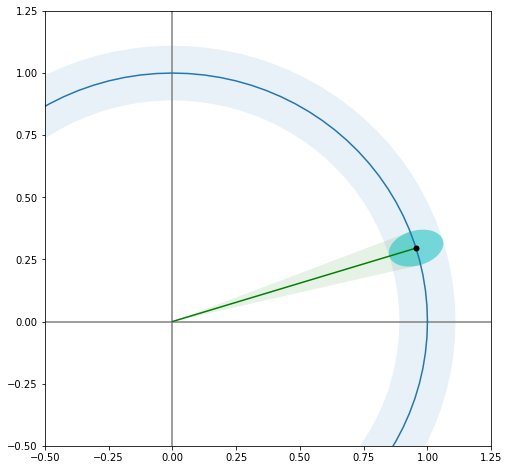

In [43]:
ipy.interact(magtime_phi_linear,
             mu_phi=ipy.FloatSlider(value=0.0, min=0.0, max=np.pi/2, step=0.1, description=r'$\mu_\phi$'),
             sigma_A=ipy.FloatSlider(value=0.1, min=0.01, max=0.2, step=0.01, description=r'$\sigma_A$'),
             sigma_phi=ipy.FloatSlider(value=0.2, min=0.01, max=np.pi/4, step=0.01, description=r'$\sigma_\phi$')
            );

# Sample error

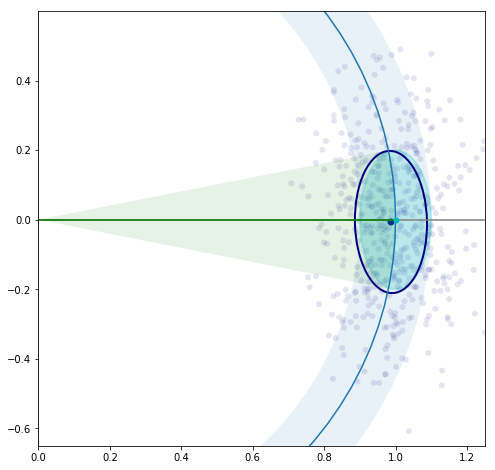

In [44]:
ipy.interact(magtime_phi_exact,
             mu_phi=ipy.FloatSlider(value=0.0, min=0.0, max=np.pi/2, step=0.1, description=r'$\mu_\phi$'),
             sigma_A=ipy.FloatSlider(value=0.1, min=0.01, max=0.2, step=0.01, description=r'$\sigma_A$'),
             sigma_phi=ipy.FloatSlider(value=0.2, min=0.01, max=np.pi/4, step=0.01, description=r'$\sigma_\phi$'),
             xlim=ipy.FloatRangeSlider(value=(-0.5, 1.25), min=-1, max=1.5, step=0.05),
             ylim=ipy.FloatRangeSlider(value=(-0.5, 1.25), min=-1, max=1.5, step=0.05));

- Random sample approximates the mean, standard deviation well,
  but is computationally intensity.
- Same benefits with many fewer points?
- Yes, *unscented transform!*

# Unscented transform

- Consider,

    $$\mathbf{y} = f(\mathbf{x})$$
- $\mathbf{x}$ distributed with mean $\mu_x$, covariance $\sigma^2_x$.
- Approximate mean $\mu_y$, covariance $\sigma^2_y$ using small number of well-chosen points $X$.

## Recipe

1. Generate a vector of sample points. A good default choice is points of the form
   $$\mu_x \pm (\sqrt{\sigma_x^2})_i$$
2. Apply non-linear transformation to $X$.
   $$Y = f(X)$$
3. Approximate the mean:
   $$\mu_y \approx \langle Y \rangle$$
4. Approximate the covariance:
   $$\sigma_y^2  \approx \left ( Y - \langle Y \rangle \right ) \left ( Y - \langle Y \rangle \right )^T $$

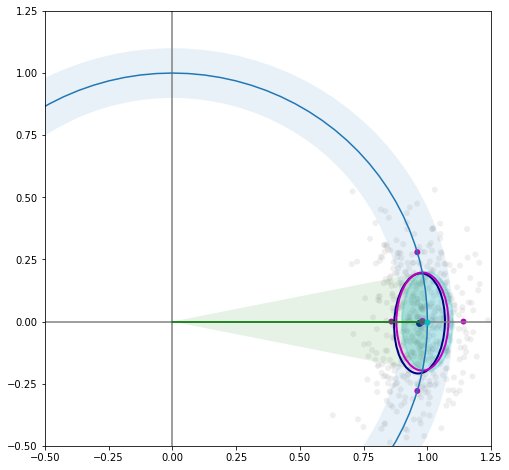

In [45]:
ipy.interact(magtime_phi_unscented,
             mu_phi=ipy.FloatSlider(value=0.0, min=0.0, max=np.pi/2, step=0.1, description=r'$\mu_\phi$'),
             sigma_A=ipy.FloatSlider(value=0.1, min=0.01, max=0.2, step=0.01, description=r'$\sigma_A$'),
             sigma_phi=ipy.FloatSlider(value=0.2, min=0.01, max=np.pi/4, step=0.01, description=r'$\sigma_\phi$'),
             xlim=ipy.FloatRangeSlider(value=(-0.5, 1.25), min=-1, max=1.5, step=0.05),
             ylim=ipy.FloatRangeSlider(value=(-0.5, 1.25), min=-1, max=1.5, step=0.05));

# Application: Unscented Kalman filter



In [46]:
x = np.array([1.0, 0.0])
cov = np.diag([0.1, 0.1])
X = unscented(x, cov)
Y = np.zeros_like(X)
for i, col in enumerate(X.T):
    Y[0, i] = col[0] * np.cos(col[1])
    Y[1, i] = col[0] * np.sin(col[1])

np.mean(Y, axis=1)
mu_y, cov_y = unscented_mu_cov(Y)

In [47]:
def magtime_phi_exact2(mu_phi, sigma_A, sigma_phi, xlim, ylim):
    mu_x = magphase(1.0, mu_phi)
    cov = np.diag([sigma_A**2, sigma_phi**2])
    phi_x = phis[:51]
    fig, ax = plt.subplots(figsize=(8,8))
    axis_color='0.5'
    
    # Add exact propogation of samples
    pts = 500
    A_pts = np.random.randn(pts)*sigma_A + 1
    phi_pts = np.random.randn(pts)*sigma_phi + mu_phi
    x_pts = A_pts * np.cos(phi_pts)
    y_pts = A_pts * np.sin(phi_pts)
    mu_xy = np.array([x_pts.mean(), y_pts.mean()])
    vec = np.c_[x_pts - x_pts.mean(), y_pts - y_pts.mean()]
    cov_pts = np.dot(vec.T, vec) / pts
    
    
    
    # Add axes
    ax.axhline(color=axis_color)
    ax.axvline(color=axis_color)
    
    # Mean circle (mu_A = 1)
    ax.plot(np.cos(phis), np.sin(phis))
    fill_donut(ax, [1-sigma_A, 1+sigma_A], edgecolor='none', alpha=0.1)
    
    
    ax.plot([0, np.cos(mu_phi)], [0, np.sin(mu_phi)], 'g')
    phi_plot = np.linspace(mu_phi+sigma_phi, mu_phi-sigma_phi, 9)
    ax.fill(np.r_[0, np.cos(phi_plot)], np.r_[0, np.sin(phi_plot)], 'g', alpha=0.1)
    ax.plot(np.cos(mu_phi), np.sin(mu_phi), color='c', marker='o', markeredgecolor='none')
    
    # Propogate error
    uA = ufloat(1.0, sigma_A)
    u_phi = ufloat(mu_phi, sigma_phi)
    ux = umath.cos(u_phi) * uA
    uy = umath.sin(u_phi) * uA
    ucov = np.array(uncertainties.covariance_matrix([ux, uy]))
    ax.add_artist(cov_ellipse((ux.n, uy.n), ucov, color='c', alpha=0.2, lw=2))
    pt_color = colors.cnames['navy']
    ax.scatter(x_pts, y_pts, c=pt_color, edgecolors='none', alpha=0.1)
    ax.scatter(*mu_xy, s=50, c=pt_color, edgecolors='none')
    ax.add_artist(cov_ellipse(mu_xy, cov_pts, edgecolor=pt_color, fill=False, lw=2.0))
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

(-0.5, 0.5)

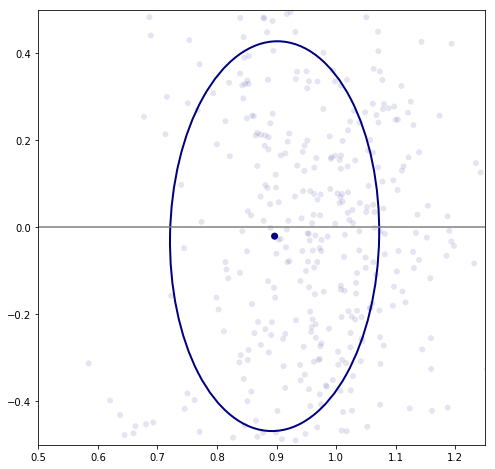

In [48]:
mu_phi = 0
sigma_phi = 0.5
sigma_A = 0.1
xlim=(0.5, 1.25)
ylim=(-0.5, 0.5)
mu_x = magphase(1.0, mu_phi)
cov = np.diag([sigma_A**2, sigma_phi**2])
phi_x = phis[:51]
fig, ax = plt.subplots(figsize=(8,8))
axis_color='0.5'

# Add exact propogation of samples
pts = 500
A_pts = np.random.randn(pts)*sigma_A + 1
phi_pts = np.random.randn(pts)*sigma_phi + mu_phi
x_pts = A_pts * np.cos(phi_pts)
y_pts = A_pts * np.sin(phi_pts)
mu_xy = np.array([x_pts.mean(), y_pts.mean()])
vec = np.c_[x_pts - x_pts.mean(), y_pts - y_pts.mean()]
cov_pts = np.dot(vec.T, vec) / pts

# Add axes
ax.axhline(color=axis_color)
ax.axvline(color=axis_color)
pt_color = colors.cnames['navy']
ax.scatter(x_pts, y_pts, c=pt_color, edgecolors='none', alpha=0.1)
ax.scatter(*mu_xy, s=50, c=pt_color, edgecolors='none')
ax.add_artist(cov_ellipse(mu_xy, cov_pts, edgecolor=pt_color, fill=False, lw=2.0))
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)

In [49]:
from scipy.stats import kde

In [50]:
import statsmodels

In [51]:
import seaborn.apionly as sns